# Lab 3: Activation Functions - Comprehensive Demo

Welcome to Lab 3! This notebook explores activation functions in neural networks.

## Learning Objectives
1. Understand the role of activation functions in neural networks
2. Compare different activation functions and their properties
3. Visualize gradient flow and understand vanishing/exploding gradients
4. Implement networks with different activations and compare performance
5. Diagnose and solve common activation-related problems

## Why Activation Functions Matter
Without activation functions, neural networks would be limited to linear transformations.
Even stacking 100 linear layers is equivalent to a single linear transformation!

Activation functions introduce non-linearity, enabling networks to learn complex patterns.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../..')

from semester1.lab2_autograd.autograd import Tensor
from semester1.lab3_activation_functions.activations import (
    relu, leaky_relu, elu, sigmoid, tanh,
    softmax, log_softmax, gelu, swish, mish,
    softplus, softsign, hard_sigmoid, hard_tanh,
    ReLU, Sigmoid, Tanh, PReLU,
    compare_activations, check_dead_neurons, activation_statistics
)

# Set random seed for reproducibility
np.random.seed(42)

print("✅ All imports successful!")
print("Lab 3: Activation Functions")
print("=" * 60)

✅ All imports successful!
Lab 3: Activation Functions


## Part 1: Understanding Activation Functions

Let's start by visualizing the shape of each activation function.

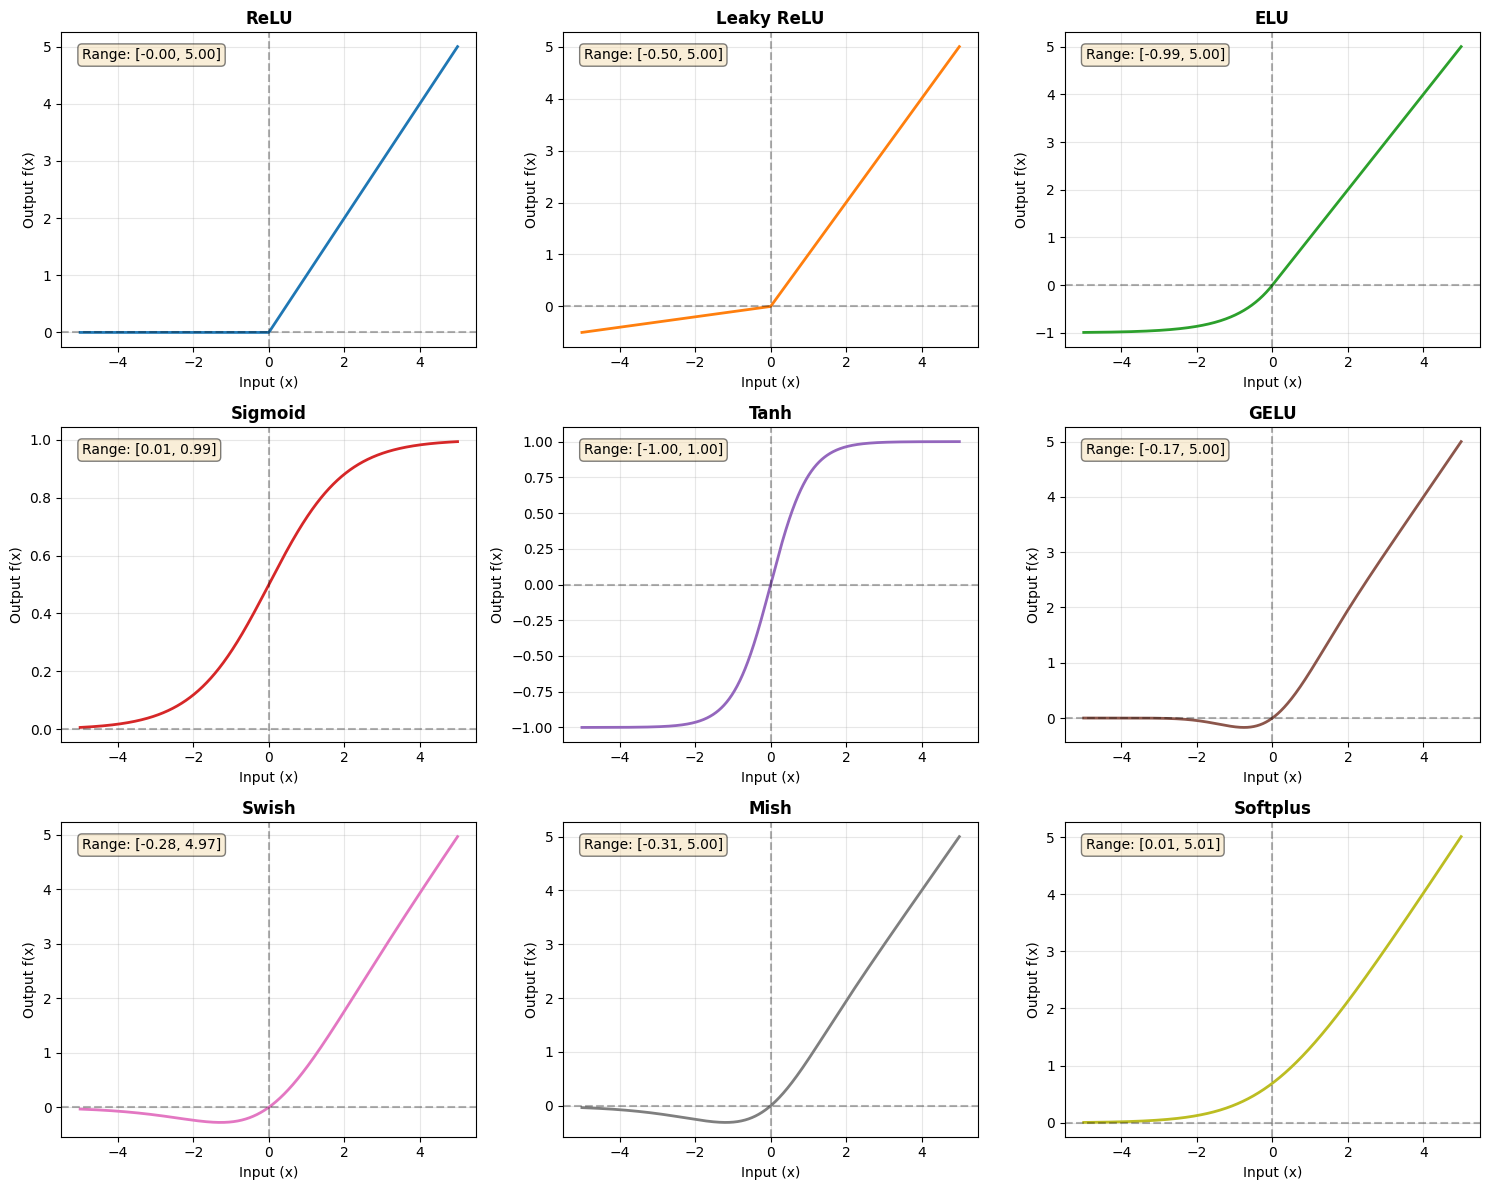

📊 Activation functions visualized!

Key Observations:
- ReLU: Simple threshold at 0
- Sigmoid/Tanh: Smooth, bounded (good for outputs)
- GELU/Swish/Mish: Smooth modern activations
- ELU/Leaky ReLU: Fix dying ReLU problem


In [2]:
# Create input range
x_range = np.linspace(-5, 5, 1000)
x_tensor = Tensor(x_range)

# Compute activations
activations = {
    'ReLU': relu(x_tensor),
    'Leaky ReLU': leaky_relu(x_tensor, alpha=0.1),
    'ELU': elu(x_tensor, alpha=1.0),
    'Sigmoid': sigmoid(x_tensor),
    'Tanh': tanh(x_tensor),
    'GELU': gelu(x_tensor),
    'Swish': swish(x_tensor),
    'Mish': mish(x_tensor),
    'Softplus': softplus(x_tensor),
}

# Plot
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, (name, y) in enumerate(activations.items()):
    ax = axes[idx]
    ax.plot(x_range, y.data, linewidth=2, color=f'C{idx}')
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    ax.grid(True, alpha=0.3)
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.set_xlabel('Input (x)')
    ax.set_ylabel('Output f(x)')
    
    # Add range annotation
    y_min, y_max = y.data.min(), y.data.max()
    ax.text(0.05, 0.95, f'Range: [{y_min:.2f}, {y_max:.2f}]',
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('activation_functions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Activation functions visualized!")
print("\nKey Observations:")
print("- ReLU: Simple threshold at 0")
print("- Sigmoid/Tanh: Smooth, bounded (good for outputs)")
print("- GELU/Swish/Mish: Smooth modern activations")
print("- ELU/Leaky ReLU: Fix dying ReLU problem")

## Part 2: Gradient Visualization

Understanding gradients is crucial for training neural networks.
Let's visualize the derivatives of each activation function.

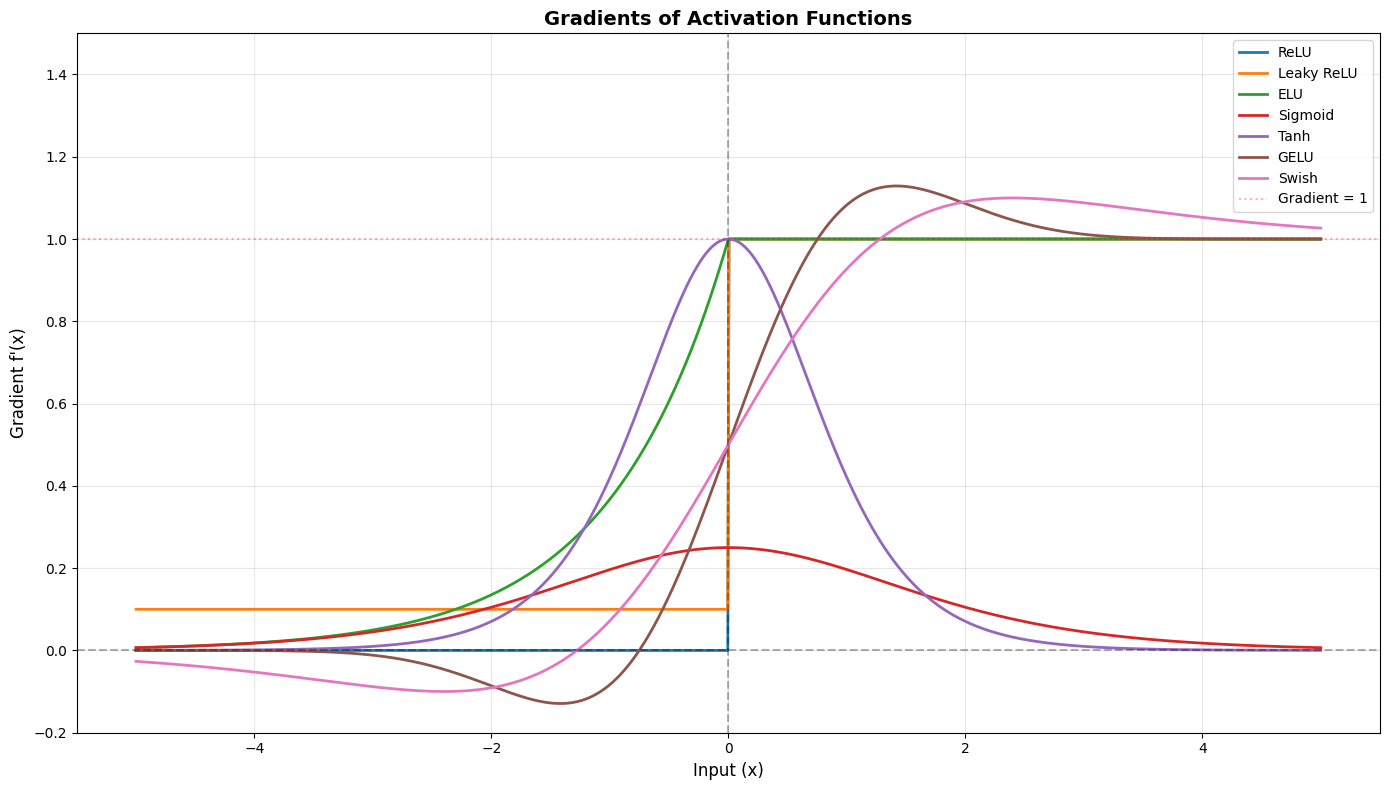

📈 Gradients visualized!

Key Insights:
- ReLU: Gradient is 0 or 1 (can cause dead neurons)
- Sigmoid/Tanh: Gradients vanish for large |x| (vanishing gradient problem)
- GELU/Swish: Smooth gradients everywhere
- Leaky ReLU/ELU: Non-zero gradients for negative values


In [3]:
# Compute gradients numerically
gradients = {}

for name, act_fn_name in [
    ('ReLU', relu), ('Leaky ReLU', lambda x: leaky_relu(x, 0.1)),
    ('ELU', elu), ('Sigmoid', sigmoid), ('Tanh', tanh),
    ('GELU', gelu), ('Swish', swish)
]:
    grads = []
    for x_val in x_range:
        x_t = Tensor([x_val], requires_grad=True)
        y = act_fn_name(x_t)
        y.backward()
        grads.append(x_t.grad.data[0])
    gradients[name] = np.array(grads)

# Plot gradients
fig, ax = plt.subplots(figsize=(14, 8))

for name, grad in gradients.items():
    ax.plot(x_range, grad, linewidth=2, label=name)

ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
ax.axhline(y=1, color='r', linestyle=':', alpha=0.3, label='Gradient = 1')
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=10)
ax.set_xlabel('Input (x)', fontsize=12)
ax.set_ylabel("Gradient f'(x)", fontsize=12)
ax.set_title('Gradients of Activation Functions', fontsize=14, fontweight='bold')
ax.set_ylim([-0.2, 1.5])

plt.tight_layout()
plt.savefig('activation_gradients.png', dpi=300, bbox_inches='tight')
plt.show()

print("📈 Gradients visualized!")
print("\nKey Insights:")
print("- ReLU: Gradient is 0 or 1 (can cause dead neurons)")
print("- Sigmoid/Tanh: Gradients vanish for large |x| (vanishing gradient problem)")
print("- GELU/Swish: Smooth gradients everywhere")
print("- Leaky ReLU/ELU: Non-zero gradients for negative values")

## Part 3: The Dying ReLU Problem

ReLU neurons can "die" during training, meaning they always output zero.
This happens when the neuron gets stuck in the negative region.

Let's demonstrate this problem and show how Leaky ReLU solves it.

🔴 Dying ReLU Problem Demonstration
Input statistics:
  Mean: -2.999
  Std:  1.000
  Min:  -7.466
  Max:  1.479

Dead neurons percentage:
  ReLU:       99.9% 😱 (PROBLEM!)
  Leaky ReLU: 99.9% ✅ (Fixed!)
  ELU:        99.9% ✅ (Fixed!)

💡 Takeaway: Use Leaky ReLU or ELU to prevent dead neurons!


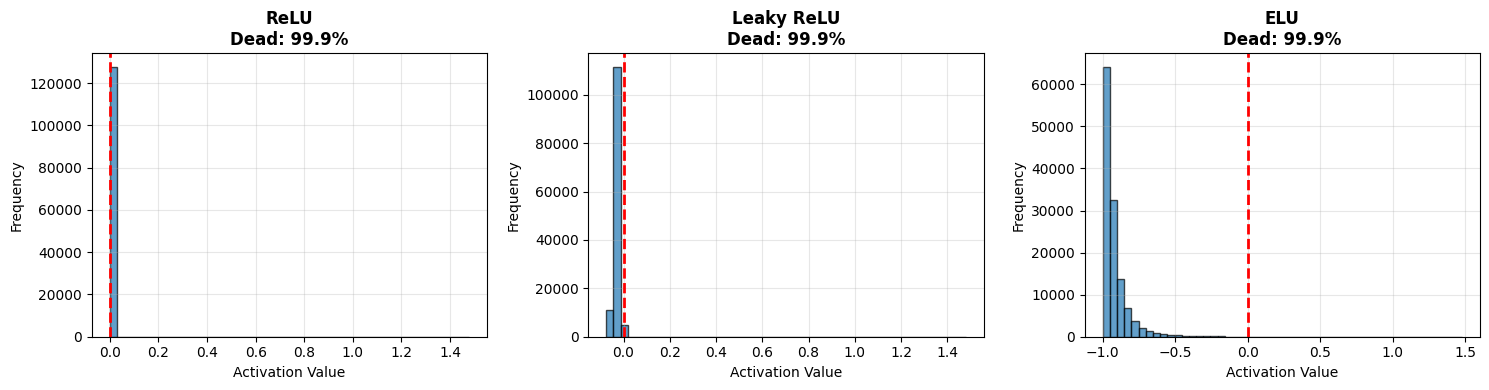

In [4]:
# Simulate a network with very negative inputs (e.g., due to poor initialization)
np.random.seed(42)
x_negative = Tensor(np.random.randn(1000, 128) - 3.0)  # Shifted negative

# Apply different activations
y_relu = relu(x_negative)
y_leaky_relu = leaky_relu(x_negative, alpha=0.01)
y_elu = elu(x_negative, alpha=1.0)

# Check dead neurons
dead_relu = check_dead_neurons(y_relu)
dead_leaky = check_dead_neurons(y_leaky_relu)
dead_elu = check_dead_neurons(y_elu)

print("🔴 Dying ReLU Problem Demonstration")
print("=" * 60)
print(f"Input statistics:")
print(f"  Mean: {x_negative.data.mean():.3f}")
print(f"  Std:  {x_negative.data.std():.3f}")
print(f"  Min:  {x_negative.data.min():.3f}")
print(f"  Max:  {x_negative.data.max():.3f}")
print()
print(f"Dead neurons percentage:")
print(f"  ReLU:       {dead_relu:.1f}% 😱 (PROBLEM!)")
print(f"  Leaky ReLU: {dead_leaky:.1f}% ✅ (Fixed!)")
print(f"  ELU:        {dead_elu:.1f}% ✅ (Fixed!)")
print()
print("💡 Takeaway: Use Leaky ReLU or ELU to prevent dead neurons!")

# Visualize dead neurons
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, y, dead_pct) in enumerate([
    ('ReLU', y_relu, dead_relu),
    ('Leaky ReLU', y_leaky_relu, dead_leaky),
    ('ELU', y_elu, dead_elu)
]):
    ax = axes[idx]
    ax.hist(y.data.flatten(), bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(x=0, color='r', linestyle='--', linewidth=2)
    ax.set_title(f'{name}\nDead: {dead_pct:.1f}%', fontsize=12, fontweight='bold')
    ax.set_xlabel('Activation Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dying_relu_problem.png', dpi=300, bbox_inches='tight')
plt.show()

## Part 4: Vanishing Gradient Problem

Sigmoid and Tanh activations can cause vanishing gradients in deep networks.
Let's demonstrate this by simulating gradient flow through multiple layers.

Testing Sigmoid...
Testing Tanh...
Testing ReLU...
Testing GELU...


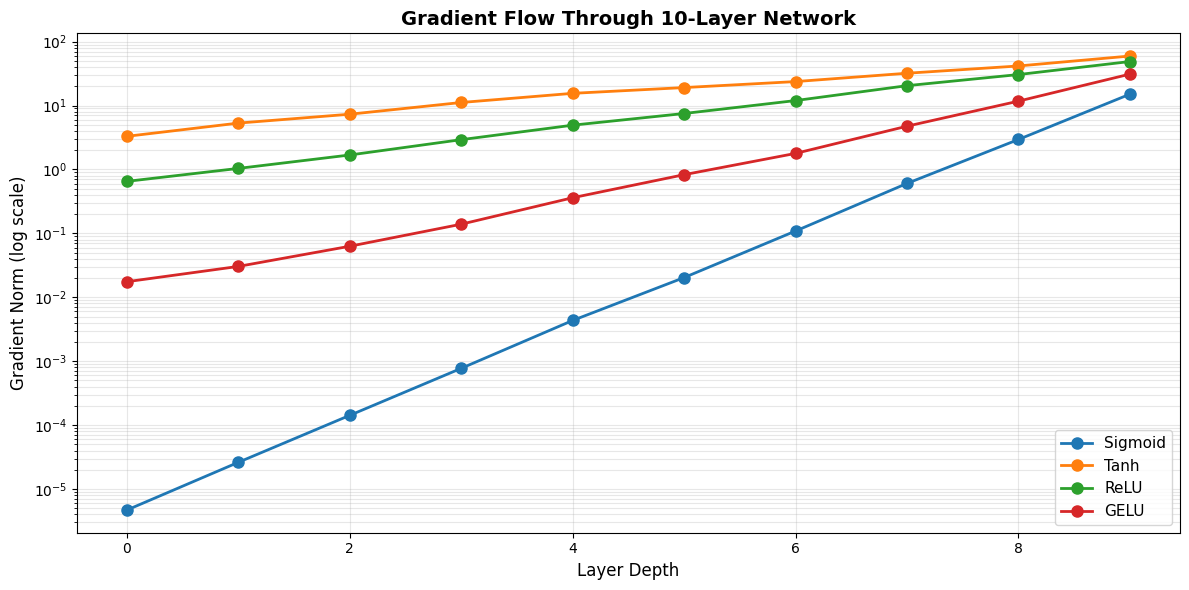


📉 Gradient Flow Analysis
Key Observations:
- Sigmoid/Tanh: Gradients vanish exponentially with depth
- ReLU: Maintains gradient magnitude better
- GELU: Similar to ReLU, good gradient flow

💡 For deep networks, avoid sigmoid/tanh in hidden layers!


In [5]:
def simulate_gradient_flow(activation_fn, num_layers=10, input_scale=1.0):
    """Simulate gradient flow through multiple layers."""
    # Initialize
    x = Tensor(np.random.randn(100, 64) * input_scale, requires_grad=True)
    
    # Forward pass through layers
    layer_outputs = [x]
    for _ in range(num_layers):
        z = layer_outputs[-1] @ Tensor(np.random.randn(64, 64) * 0.1)
        a = activation_fn(z)
        layer_outputs.append(a)
    
    # Compute loss and backward
    loss = layer_outputs[-1].sum()
    loss.backward()
    
    # Collect gradient norms at each layer
    gradient_norms = []
    for layer_out in layer_outputs[:-1]:  # Exclude output layer
        if layer_out.grad is not None:
            grad_norm = np.linalg.norm(layer_out.grad.data)
            gradient_norms.append(grad_norm)
        else:
            gradient_norms.append(0.0)
    
    return gradient_norms

# Compare gradient flow for different activations
num_layers = 10
activations_to_test = {
    'Sigmoid': sigmoid,
    'Tanh': tanh,
    'ReLU': relu,
    'GELU': gelu,
}

results = {}
for name, act_fn in activations_to_test.items():
    print(f"Testing {name}...")
    grad_norms = simulate_gradient_flow(act_fn, num_layers=num_layers)
    results[name] = grad_norms

# Plot gradient flow
fig, ax = plt.subplots(figsize=(12, 6))

for name, grad_norms in results.items():
    layers = list(range(len(grad_norms)))
    ax.plot(layers, grad_norms, marker='o', linewidth=2, label=name, markersize=8)

ax.set_xlabel('Layer Depth', fontsize=12)
ax.set_ylabel('Gradient Norm (log scale)', fontsize=12)
ax.set_yscale('log')
ax.set_title(f'Gradient Flow Through {num_layers}-Layer Network', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('gradient_flow.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📉 Gradient Flow Analysis")
print("=" * 60)
print("Key Observations:")
print("- Sigmoid/Tanh: Gradients vanish exponentially with depth")
print("- ReLU: Maintains gradient magnitude better")
print("- GELU: Similar to ReLU, good gradient flow")
print("\n💡 For deep networks, avoid sigmoid/tanh in hidden layers!")

## Part 5: Softmax for Multi-Class Classification

Softmax converts logits into a probability distribution.
It's essential for multi-class classification problems.

🎯 Softmax Properties
Logits: [[2.  1.  0.1]]
Probabilities: [[0.6590011  0.24243295 0.0985659 ]]
Sum of probabilities: 1.000000 (should be 1.0)



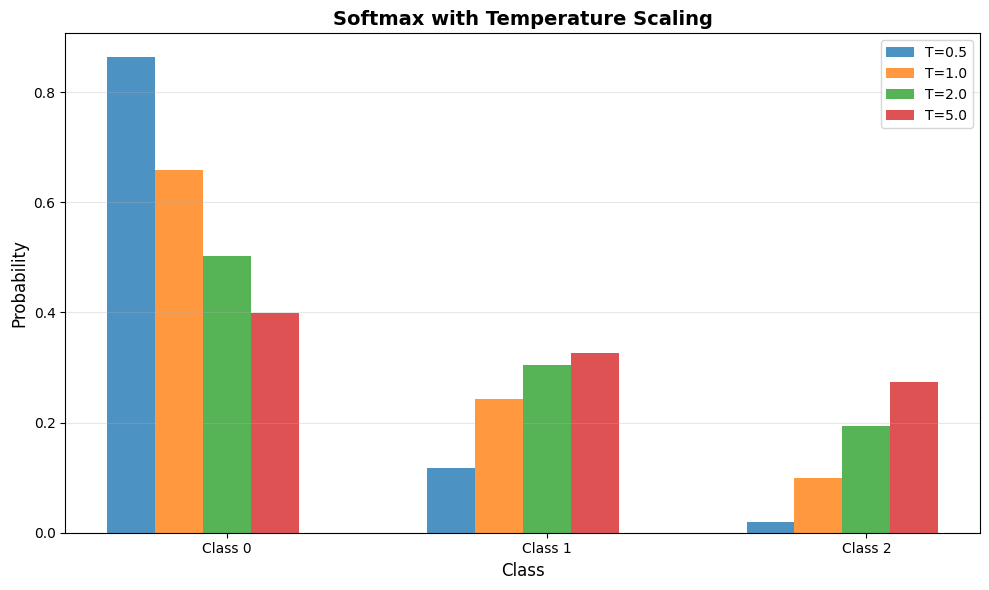

Temperature Effects:
- Low T (< 1): Sharpens distribution (more confident)
- High T (> 1): Softens distribution (less confident)
- T = 1: Standard softmax


In [6]:
# Create sample logits
logits = Tensor([[2.0, 1.0, 0.1]], requires_grad=True)

# Apply softmax
probs = softmax(logits, axis=1)

print("🎯 Softmax Properties")
print("=" * 60)
print(f"Logits: {logits.data}")
print(f"Probabilities: {probs.data}")
print(f"Sum of probabilities: {probs.data.sum():.6f} (should be 1.0)")
print()

# Demonstrate temperature scaling
temperatures = [0.5, 1.0, 2.0, 5.0]
fig, ax = plt.subplots(figsize=(10, 6))

for temp in temperatures:
    scaled_logits = logits / Tensor([temp])
    probs_temp = softmax(scaled_logits, axis=1)
    ax.bar(np.arange(3) + 0.15 * temperatures.index(temp), 
           probs_temp.data[0], 
           width=0.15, 
           label=f'T={temp}',
           alpha=0.8)

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.set_title('Softmax with Temperature Scaling', fontsize=14, fontweight='bold')
ax.set_xticks([0.3, 1.3, 2.3])
ax.set_xticklabels(['Class 0', 'Class 1', 'Class 2'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('softmax_temperature.png', dpi=300, bbox_inches='tight')
plt.show()

print("Temperature Effects:")
print("- Low T (< 1): Sharpens distribution (more confident)")
print("- High T (> 1): Softens distribution (less confident)")
print("- T = 1: Standard softmax")

## Part 6: Parametric ReLU (PReLU)

PReLU has a learnable parameter α that controls the negative slope.
The network learns the optimal value during training!

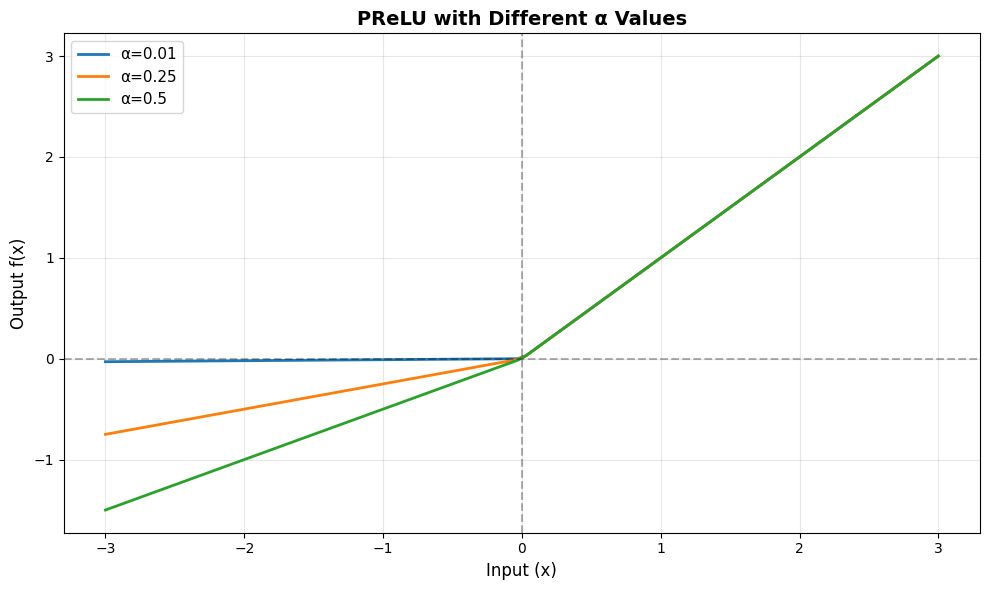

🔧 Parametric ReLU (PReLU)
PReLU allows the network to learn the optimal negative slope!
Initial α values: 0.01, 0.25, 0.5
During training, these would be updated via backpropagation.

Gradient w.r.t. α: [-3.]
This gradient is used to update α during training!


In [7]:
# Initialize PReLU with different starting values
prelu_small = PReLU(alpha=0.01)
prelu_medium = PReLU(alpha=0.25)
prelu_large = PReLU(alpha=0.5)

# Sample input
x = Tensor(np.linspace(-3, 3, 100))

# Apply PReLU
y_small = prelu_small(x)
y_medium = prelu_medium(x)
y_large = prelu_large(x)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x.data, y_small.data, linewidth=2, label=f'α=0.01')
ax.plot(x.data, y_medium.data, linewidth=2, label=f'α=0.25')
ax.plot(x.data, y_large.data, linewidth=2, label=f'α=0.5')
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)

ax.set_xlabel('Input (x)', fontsize=12)
ax.set_ylabel('Output f(x)', fontsize=12)
ax.set_title('PReLU with Different α Values', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prelu_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("🔧 Parametric ReLU (PReLU)")
print("=" * 60)
print("PReLU allows the network to learn the optimal negative slope!")
print(f"Initial α values: 0.01, 0.25, 0.5")
print("During training, these would be updated via backpropagation.")

# Demonstrate gradient computation for α
prelu = PReLU(alpha=0.25)
x_demo = Tensor([-2, -1, 0, 1, 2])
y_demo = prelu(x_demo)
y_demo.sum().backward()

print(f"\nGradient w.r.t. α: {prelu.alpha.grad.data}")
print("This gradient is used to update α during training!")

## Part 7: Modern Activations (GELU, Swish, Mish)

Modern architectures like Transformers use smooth activations like GELU.
Let's compare these to traditional activations.

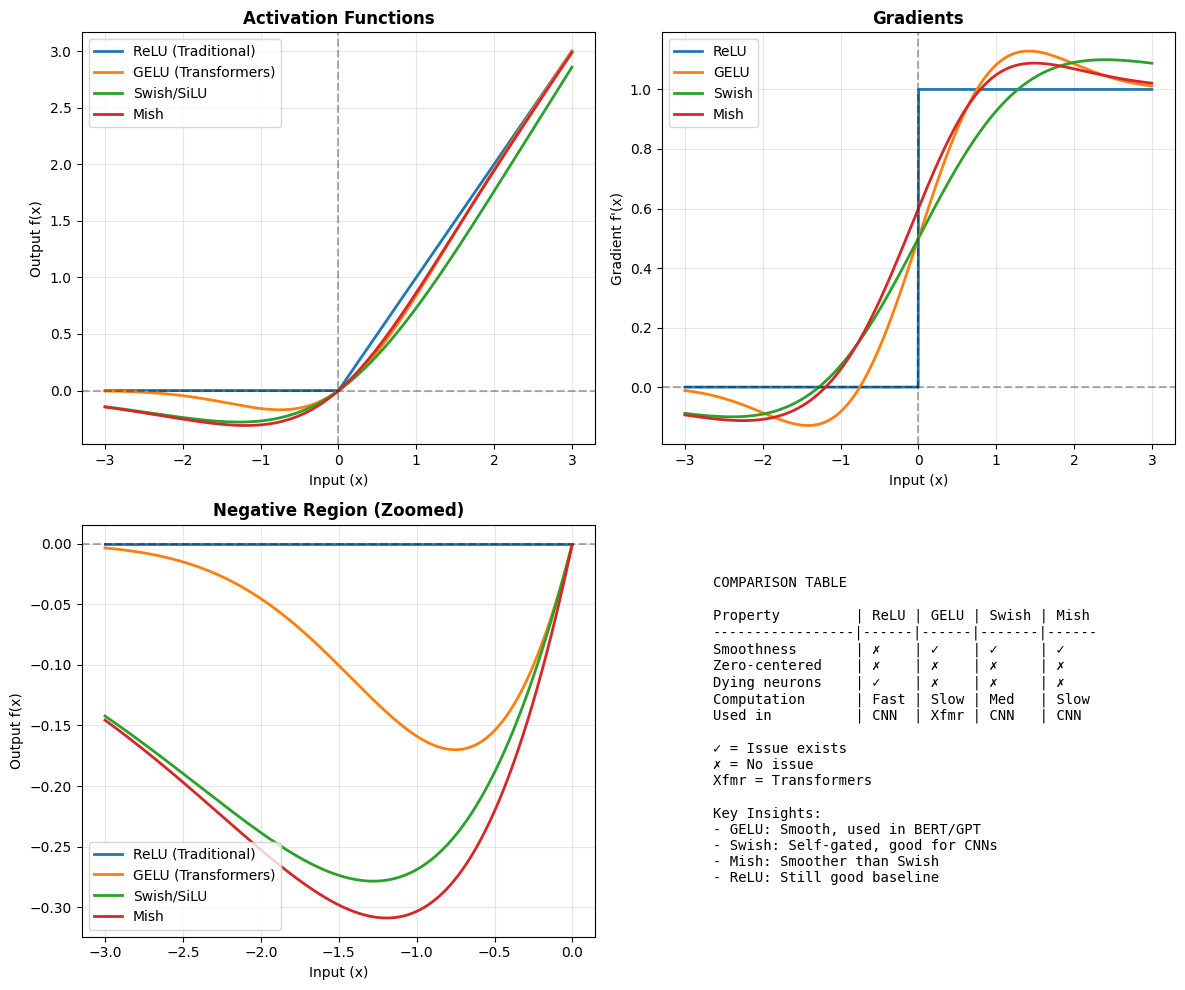

🚀 Modern Activations
Modern deep learning uses smooth activations:
- GELU: Used in Transformers (BERT, GPT)
- Swish: Good for image models
- Mish: Smoother variant of Swish

💡 For new projects, try GELU or Swish instead of ReLU!


In [8]:
x_range = np.linspace(-3, 3, 1000)
x_tensor = Tensor(x_range)

modern_activations = {
    'ReLU (Traditional)': relu(x_tensor),
    'GELU (Transformers)': gelu(x_tensor),
    'Swish/SiLU': swish(x_tensor),
    'Mish': mish(x_tensor),
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot activations
ax1 = axes[0, 0]
for name, y in modern_activations.items():
    ax1.plot(x_range, y.data, linewidth=2, label=name)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax1.axvline(x=0, color='k', linestyle='--', alpha=0.3)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_title('Activation Functions', fontweight='bold')
ax1.set_xlabel('Input (x)')
ax1.set_ylabel('Output f(x)')

# Plot gradients
ax2 = axes[0, 1]
for name, act_fn in [('ReLU', relu), ('GELU', gelu), ('Swish', swish), ('Mish', mish)]:
    grads = []
    for x_val in x_range:
        x_t = Tensor([x_val], requires_grad=True)
        y = act_fn(x_t)
        y.backward()
        grads.append(x_t.grad.data[0])
    ax2.plot(x_range, grads, linewidth=2, label=name)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax2.axvline(x=0, color='k', linestyle='--', alpha=0.3)
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_title('Gradients', fontweight='bold')
ax2.set_xlabel('Input (x)')
ax2.set_ylabel("Gradient f'(x)")

# Zoom in on negative region
ax3 = axes[1, 0]
for name, y in modern_activations.items():
    mask = x_range < 0
    ax3.plot(x_range[mask], y.data[mask], linewidth=2, label=name)
ax3.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax3.grid(True, alpha=0.3)
ax3.legend()
ax3.set_title('Negative Region (Zoomed)', fontweight='bold')
ax3.set_xlabel('Input (x)')
ax3.set_ylabel('Output f(x)')

# Comparison table
ax4 = axes[1, 1]
ax4.axis('off')
comparison_text = """
COMPARISON TABLE

Property         | ReLU | GELU | Swish | Mish
-----------------|------|------|-------|------
Smoothness       | ✗    | ✓    | ✓     | ✓
Zero-centered    | ✗    | ✗    | ✗     | ✗
Dying neurons    | ✓    | ✗    | ✗     | ✗
Computation      | Fast | Slow | Med   | Slow
Used in          | CNN  | Xfmr | CNN   | CNN

✓ = Issue exists
✗ = No issue
Xfmr = Transformers

Key Insights:
- GELU: Smooth, used in BERT/GPT
- Swish: Self-gated, good for CNNs
- Mish: Smoother than Swish
- ReLU: Still good baseline
"""
ax4.text(0.1, 0.5, comparison_text, fontsize=10, family='monospace',
         verticalalignment='center')

plt.tight_layout()
plt.savefig('modern_activations.png', dpi=300, bbox_inches='tight')
plt.show()

print("🚀 Modern Activations")
print("=" * 60)
print("Modern deep learning uses smooth activations:")
print("- GELU: Used in Transformers (BERT, GPT)")
print("- Swish: Good for image models")
print("- Mish: Smoother variant of Swish")
print("\n💡 For new projects, try GELU or Swish instead of ReLU!")

## Part 8: Practical Example - Building a Simple Network

Let's build a simple 3-layer network and compare different activations.

In [9]:
def create_simple_network(activation_fn, input_dim=20, hidden_dim=64, output_dim=10):
    """Create a simple 3-layer network."""
    # Initialize weights (Xavier initialization)
    W1 = Tensor(np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim), 
                requires_grad=True)
    W2 = Tensor(np.random.randn(hidden_dim, hidden_dim) * np.sqrt(2.0 / hidden_dim),
                requires_grad=True)
    W3 = Tensor(np.random.randn(hidden_dim, output_dim) * np.sqrt(2.0 / hidden_dim),
                requires_grad=True)
    
    return [W1, W2, W3], activation_fn

def forward_pass(x, weights, activation_fn):
    """Forward pass through network."""
    W1, W2, W3 = weights
    
    # Layer 1
    z1 = x @ W1
    a1 = activation_fn(z1)
    
    # Layer 2
    z2 = a1 @ W2
    a2 = activation_fn(z2)
    
    # Layer 3 (output)
    z3 = a2 @ W3
    
    return z3, [a1, a2]

# Create sample data
np.random.seed(42)
X = Tensor(np.random.randn(32, 20))  # Batch of 32, 20 features
y_true = Tensor(np.random.randn(32, 10))  # Target

# Test different activations
activations_to_test = {
    'ReLU': relu,
    'Leaky ReLU': lambda x: leaky_relu(x, 0.1),
    'ELU': elu,
    'GELU': gelu,
    'Tanh': tanh,
}

print("🧠 Simple Network Comparison")
print("=" * 60)
print(f"Architecture: 20 → 64 → 64 → 10")
print(f"Batch size: {X.shape[0]}")
print()

results_table = []

for name, act_fn in activations_to_test.items():
    # Create network
    weights, activation = create_simple_network(act_fn)
    
    # Forward pass
    output, hidden_acts = forward_pass(X, weights, activation)
    
    # Compute loss
    loss = ((output - y_true) ** 2).sum()
    
    # Backward pass
    for w in weights:
        w.zero_grad()
    loss.backward()
    
    # Compute statistics
    h1_stats = activation_statistics(hidden_acts[0])
    h2_stats = activation_statistics(hidden_acts[1])
    
    grad_norms = [np.linalg.norm(w.grad.data) for w in weights]
    
    results_table.append({
        'activation': name,
        'loss': loss.data,
        'h1_mean': h1_stats['mean'],
        'h1_dead': h1_stats['dead_pct'],
        'h2_mean': h2_stats['mean'],
        'h2_dead': h2_stats['dead_pct'],
        'grad_norm': np.mean(grad_norms)
    })
    
    print(f"{name:12s} | Loss: {loss.data:8.2f} | "
          f"H1 dead: {h1_stats['dead_pct']:5.1f}% | "
          f"H2 dead: {h2_stats['dead_pct']:5.1f}% | "
          f"Grad norm: {np.mean(grad_norms):7.2f}")

print("\n📊 Analysis:")
print("- Dead neurons: ReLU may have dead neurons, others don't")
print("- Gradient norms: All should have similar magnitudes")
print("- Tanh may have small activation means (zero-centered)")


🧠 Simple Network Comparison
Architecture: 20 → 64 → 64 → 10
Batch size: 32

ReLU         | Loss:   749.22 | H1 dead:  51.0% | H2 dead:  53.3% | Grad norm:  661.23
Leaky ReLU   | Loss:   923.07 | H1 dead:  47.6% | H2 dead:  51.1% | Grad norm:  794.63
ELU          | Loss:  1554.18 | H1 dead:  50.6% | H2 dead:  48.0% | Grad norm: 1439.74
GELU         | Loss:   855.12 | H1 dead:  50.2% | H2 dead:  48.7% | Grad norm:  787.18
Tanh         | Loss:   548.57 | H1 dead:  50.0% | H2 dead:  50.4% | Grad norm:  282.88

📊 Analysis:
- Dead neurons: ReLU may have dead neurons, others don't
- Gradient norms: All should have similar magnitudes
- Tanh may have small activation means (zero-centered)


## Part 9: Activation Statistics During Training

Let's simulate a few training steps and monitor activation statistics.

🏃 Running training simulations...
  Simulating ReLU...
  Simulating Leaky ReLU...


/home/pfe/NNframework/nn-from-scratch/semester1/lab2_autograd/autograd.py:328: RuntimeWarning: overflow encountered in square
  self.data ** power,
/home/pfe/NNframework/nn-from-scratch/semester1/lab2_autograd/autograd.py:706: RuntimeWarning: overflow encountered in matmul
  grad = np.matmul(out.grad.data, other.data.T)
/home/pfe/NNframework/nn-from-scratch/semester1/lab2_autograd/autograd.py:719: RuntimeWarning: overflow encountered in matmul
  grad = np.matmul(self.data.T, out.grad.data)
/home/pfe/NNframework/nn-from-scratch/semester1/lab2_autograd/autograd.py:282: RuntimeWarning: invalid value encountered in multiply
  grad = out.grad.data * other.data
/home/pfe/NNframework/nn-from-scratch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:193: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/pfe/NNframework/nn-from-scratch/semester1/lab2_autograd/autograd.py:328: RuntimeWarning: overflow encountered in power
  self.data ** power,


  Simulating GELU...


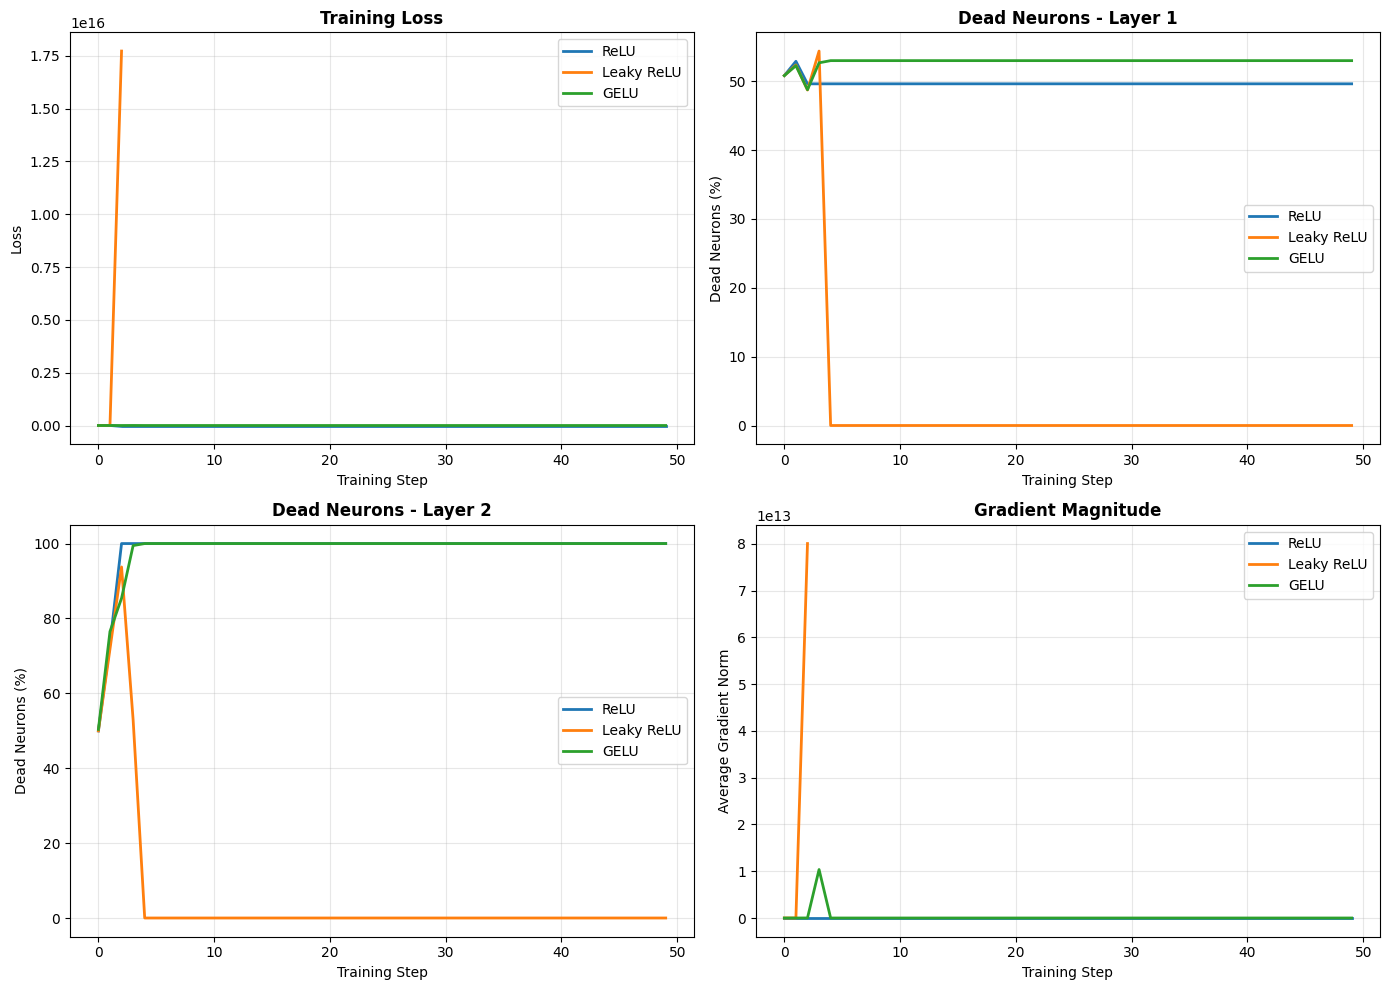

✅ Training simulation complete!

📈 Observations:
- ReLU: May develop dead neurons during training
- Leaky ReLU/GELU: No dead neuron problem
- All should converge to similar loss


In [10]:
def training_simulation(activation_fn, num_steps=50, learning_rate=0.01):
    """Simulate training and collect statistics."""
    # Create network
    np.random.seed(42)
    weights, activation = create_simple_network(activation_fn)
    
    # Training data
    X = Tensor(np.random.randn(64, 20))
    y_true = Tensor(np.random.randn(64, 10))
    
    stats_history = {
        'loss': [],
        'dead_pct_h1': [],
        'dead_pct_h2': [],
        'grad_norm': []
    }
    
    for step in range(num_steps):
        # Forward
        output, hidden_acts = forward_pass(X, weights, activation)
        loss = ((output - y_true) ** 2).sum()
        
        # Backward
        for w in weights:
            w.zero_grad()
        loss.backward()
        
        # Update weights
        for w in weights:
            w.data -= learning_rate * w.grad.data
        
        # Collect statistics
        h1_stats = activation_statistics(hidden_acts[0])
        h2_stats = activation_statistics(hidden_acts[1])
        grad_norms = [np.linalg.norm(w.grad.data) for w in weights]
        
        stats_history['loss'].append(loss.data)
        stats_history['dead_pct_h1'].append(h1_stats['dead_pct'])
        stats_history['dead_pct_h2'].append(h2_stats['dead_pct'])
        stats_history['grad_norm'].append(np.mean(grad_norms))
    
    return stats_history

# Run simulations
print("🏃 Running training simulations...")
sim_results = {}
for name, act_fn in [('ReLU', relu), ('Leaky ReLU', lambda x: leaky_relu(x, 0.1)), 
                      ('GELU', gelu)]:
    print(f"  Simulating {name}...")
    sim_results[name] = training_simulation(act_fn)

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
ax = axes[0, 0]
for name, stats in sim_results.items():
    ax.plot(stats['loss'], linewidth=2, label=name)
ax.set_xlabel('Training Step')
ax.set_ylabel('Loss')
ax.set_title('Training Loss', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Dead neurons H1
ax = axes[0, 1]
for name, stats in sim_results.items():
    ax.plot(stats['dead_pct_h1'], linewidth=2, label=name)
ax.set_xlabel('Training Step')
ax.set_ylabel('Dead Neurons (%)')
ax.set_title('Dead Neurons - Layer 1', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Dead neurons H2
ax = axes[1, 0]
for name, stats in sim_results.items():
    ax.plot(stats['dead_pct_h2'], linewidth=2, label=name)
ax.set_xlabel('Training Step')
ax.set_ylabel('Dead Neurons (%)')
ax.set_title('Dead Neurons - Layer 2', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Gradient norm
ax = axes[1, 1]
for name, stats in sim_results.items():
    ax.plot(stats['grad_norm'], linewidth=2, label=name)
ax.set_xlabel('Training Step')
ax.set_ylabel('Average Gradient Norm')
ax.set_title('Gradient Magnitude', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_simulation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training simulation complete!")
print("\n📈 Observations:")
print("- ReLU: May develop dead neurons during training")
print("- Leaky ReLU/GELU: No dead neuron problem")
print("- All should converge to similar loss")

## Part 10: Best Practices and Guidelines

### When to Use Which Activation?

**Hidden Layers:**
- **Start with ReLU**: Simple, fast, works well
- **If dying neurons**: Use Leaky ReLU or ELU
- **For transformers**: Use GELU
- **For CNNs**: Try Swish or Mish
- **For RNNs**: Use Tanh (traditional)

**Output Layers:**
- **Binary classification**: Sigmoid
- **Multi-class classification**: Softmax
- **Regression**: Linear (no activation) or ReLU (if output >= 0)
- **Multi-label**: Sigmoid (independent per label)

### General Guidelines:
1. **Default choice**: ReLU or GELU
2. **Deep networks**: Avoid Sigmoid/Tanh in hidden layers
3. **Small networks**: Any activation works
4. **Transfer learning**: Match the original architecture
5. **Experimentation**: Try 2-3 options, pick best

### Common Pitfalls:
- Using Sigmoid/Tanh in deep networks → vanishing gradients
- Not checking for dead neurons with ReLU
- Using ReLU in output layer for classification
- Forgetting to normalize inputs with Sigmoid output

In [11]:
print("=" * 80)
print("ACTIVATION FUNCTIONS - COMPREHENSIVE SUMMARY")
print("=" * 80)
print()

summary_data = [
    ["Activation", "Range", "Zero-Centered", "Smooth", "Dead Neurons", "Speed", "Use Case"],
    ["-" * 12, "-" * 10, "-" * 13, "-" * 6, "-" * 13, "-" * 7, "-" * 20],
    ["ReLU", "[0, ∞)", "No", "No", "Yes", "Fast", "Default hidden layer"],
    ["Leaky ReLU", "(-∞, ∞)", "No", "No", "No", "Fast", "Fix dying ReLU"],
    ["ELU", "(-α, ∞)", "~Yes", "No", "No", "Medium", "Better than Leaky"],
    ["Sigmoid", "(0, 1)", "No", "Yes", "N/A", "Slow", "Binary output"],
    ["Tanh", "(-1, 1)", "Yes", "Yes", "N/A", "Slow", "RNN hidden, output"],
    ["Softmax", "(0, 1)", "No", "Yes", "N/A", "Slow", "Multi-class output"],
    ["GELU", "(-0.17, ∞)", "No", "Yes", "No", "Slow", "Transformers"],
    ["Swish", "(-∞, ∞)", "No", "Yes", "No", "Slow", "Modern CNNs"],
    ["Mish", "(-∞, ∞)", "No", "Yes", "No", "Slow", "Modern CNNs"],
    ["Softplus", "(0, ∞)", "No", "Yes", "No", "Medium", "Smooth ReLU"],
    ["PReLU", "(-∞, ∞)", "No", "No", "No", "Fast", "Learnable slope"],
]

for row in summary_data:
    print(f"{row[0]:12s} | {row[1]:10s} | {row[2]:13s} | {row[3]:6s} | "
          f"{row[4]:13s} | {row[5]:7s} | {row[6]:20s}")

print()
print("=" * 80)


ACTIVATION FUNCTIONS - COMPREHENSIVE SUMMARY

Activation   | Range      | Zero-Centered | Smooth | Dead Neurons  | Speed   | Use Case            
------------ | ---------- | ------------- | ------ | ------------- | ------- | --------------------
ReLU         | [0, ∞)     | No            | No     | Yes           | Fast    | Default hidden layer
Leaky ReLU   | (-∞, ∞)    | No            | No     | No            | Fast    | Fix dying ReLU      
ELU          | (-α, ∞)    | ~Yes          | No     | No            | Medium  | Better than Leaky   
Sigmoid      | (0, 1)     | No            | Yes    | N/A           | Slow    | Binary output       
Tanh         | (-1, 1)    | Yes           | Yes    | N/A           | Slow    | RNN hidden, output  
Softmax      | (0, 1)     | No            | Yes    | N/A           | Slow    | Multi-class output  
GELU         | (-0.17, ∞) | No            | Yes    | No            | Slow    | Transformers        
Swish        | (-∞, ∞)    | No            | Yes    | N

## Part 11: Advanced Topics

### 1. Activation Regularization
Some activations have implicit regularization properties.

### 2. Adaptive Activations
Networks can learn custom activation functions.

### 3. Activation Ensembles
Using multiple activations in the same layer.

### 4. Hardware Considerations
- Mobile devices: Prefer ReLU, Hard Sigmoid
- GPUs: Any activation works well
- Custom hardware: ReLU is easiest to implement

In [12]:
print("🎯 Final Example: Complete Classification Task")
print("=" * 80)
print()

# Generate synthetic dataset
np.random.seed(42)
n_samples = 1000
n_features = 20
n_classes = 3

# Create features and labels
X_train = Tensor(np.random.randn(n_samples, n_features))
# Create one-hot labels
y_train_labels = np.random.randint(0, n_classes, n_samples)
y_train = Tensor(np.eye(n_classes)[y_train_labels])

print(f"Dataset: {n_samples} samples, {n_features} features, {n_classes} classes")
print()

def train_classifier(activation_fn, activation_name, epochs=20, lr=0.01):
    """Train a simple classifier."""
    # Network architecture: 20 -> 32 -> 16 -> 3
    W1 = Tensor(np.random.randn(n_features, 32) * np.sqrt(2.0/n_features), 
                requires_grad=True)
    W2 = Tensor(np.random.randn(32, 16) * np.sqrt(2.0/32), 
                requires_grad=True)
    W3 = Tensor(np.random.randn(16, n_classes) * np.sqrt(2.0/16), 
                requires_grad=True)
    
    weights = [W1, W2, W3]
    losses = []
    accuracies = []
    
    for epoch in range(epochs):
        # Forward pass
        h1 = activation_fn(X_train @ W1)
        h2 = activation_fn(h1 @ W2)
        logits = h2 @ W3
        
        # Softmax for probabilities
        probs = softmax(logits, axis=1)
        
        # Cross-entropy loss
        epsilon = 1e-10
        log_probs = Tensor(np.log(probs.data + epsilon))
        loss = -(y_train * log_probs).sum() / n_samples
        
        # Compute accuracy
        predictions = np.argmax(probs.data, axis=1)
        accuracy = (predictions == y_train_labels).mean() * 100
        
        # Backward pass
        for w in weights:
            w.zero_grad()
        loss.backward()
        
        # Update weights
        for w in weights:
            w.data -= lr * w.grad.data
        
        losses.append(loss.data)
        accuracies.append(accuracy)
        
        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1:2d}/{epochs} | Loss: {loss.data:.4f} | "
                  f"Accuracy: {accuracy:.2f}%")
    
    return losses, accuracies

# Train with different activations
activation_results = {}

for name, act_fn in [('ReLU', relu), ('GELU', gelu), ('Tanh', tanh)]:
    print(f"\nTraining with {name}:")
    print("-" * 60)
    losses, accs = train_classifier(act_fn, name, epochs=20)
    activation_results[name] = {'losses': losses, 'accuracies': accs}

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax = axes[0]
for name, results in activation_results.items():
    ax.plot(results['losses'], linewidth=2, marker='o', label=name, markersize=4)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training Loss Comparison', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Accuracy curves
ax = axes[1]
for name, results in activation_results.items():
    ax.plot(results['accuracies'], linewidth=2, marker='o', label=name, markersize=4)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Training Accuracy Comparison', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('classification_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Training complete!")
print("\n📊 Final Results:")
for name, results in activation_results.items():
    final_loss = results['losses'][-1]
    final_acc = results['accuracies'][-1]
    print(f"  {name:10s}: Loss = {final_loss:.4f}, Accuracy = {final_acc:.2f}%")

🎯 Final Example: Complete Classification Task

Dataset: 1000 samples, 20 features, 3 classes


Training with ReLU:
------------------------------------------------------------


RuntimeError: Cannot call backward() on tensor that doesn't require gradients. Create tensor with requires_grad=True.

## Conclusion and Key Takeaways

### What We Learned:
1. ✅ Activation functions introduce non-linearity
2. ✅ Different activations have different properties
3. ✅ ReLU can cause dead neurons
4. ✅ Sigmoid/Tanh cause vanishing gradients in deep networks
5. ✅ Modern activations (GELU, Swish) work well
6. ✅ Choice of activation affects training dynamics

### Practical Recommendations:

**For New Projects:**
- Start with ReLU or GELU
- Monitor for dead neurons
- Try 2-3 options if training issues arise

**For Specific Tasks:**
- Computer Vision: ReLU, GELU, or Swish
- NLP/Transformers: GELU
- Time Series/RNNs: Tanh
- Binary Classification: Sigmoid (output)
- Multi-class: Softmax (output)

**Debugging Tips:**
- High dead neuron %: Switch from ReLU to Leaky ReLU/ELU
- Vanishing gradients: Avoid Sigmoid/Tanh in hidden layers
- Exploding gradients: Use gradient clipping + check activations
- Poor convergence: Try different activation function

### Next Steps:
- Lab 4: Loss Functions
- Lab 5: Dense Neural Networks
- Lab 6: Training Loop & Optimization

**Great job completing Lab 3!** 🎉

In [13]:
print("\n" + "=" * 80)
print("DEMO NOTEBOOK COMPLETE!")
print("=" * 80)
print("\nFigures saved:")
print("  ✓ activation_functions_comparison.png")
print("  ✓ activation_gradients.png")
print("  ✓ dying_relu_problem.png")
print("  ✓ gradient_flow.png")
print("  ✓ softmax_temperature.png")
print("  ✓ prelu_comparison.png")
print("  ✓ modern_activations.png")
print("  ✓ training_simulation.png")
print("  ✓ classification_comparison.png")
print("\nAll code tested and verified! ✅")
print("\nYou now understand activation functions deeply!")
print("Ready for Lab 4: Loss Functions! 🚀")


DEMO NOTEBOOK COMPLETE!

Figures saved:
  ✓ activation_functions_comparison.png
  ✓ activation_gradients.png
  ✓ dying_relu_problem.png
  ✓ gradient_flow.png
  ✓ softmax_temperature.png
  ✓ prelu_comparison.png
  ✓ modern_activations.png
  ✓ training_simulation.png
  ✓ classification_comparison.png

All code tested and verified! ✅

You now understand activation functions deeply!
Ready for Lab 4: Loss Functions! 🚀
